In [3]:
from __future__ import absolute_import from __future__ import division
from __future__ import print_function

import time, random
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
sess = tf.InteractiveSession()

def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input")
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name="bias")

def max_pool_2x2(x, name = ""):
    name = name if name != "" else 'max_pool_' + str(random.randint(1, 1 << 30))
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(prev_layer, n_output, filter_width, activation = tf.identity, stride = 1, name = ""):
    name = name if name != "" else 'conv_' + str(random.randint(1, 1 << 30))
    
    width_prev_layer = int(prev_layer.get_shape()[3])
    with tf.name_scope(name):
        Weight_mat = weight_variable([filter_width, filter_width, width_prev_layer, n_output])
        variable_summaries(Weight_mat, name+'/weights')
        res = tf.nn.conv2d(
            prev_layer, 
            Weight_mat, 
            strides=[1, stride, stride, 1], 
            padding='SAME') + bias_variable([n_output])
        return activation(res)

def full_connect_layer(prev_layer, n_output, activation = tf.identity, name = ""):
    """
    transform the previous layer to a "flat" matrix
    And then fully connect to the next layer

    input:
    prev_layer: The previous layer
    activation: ghd activation function of the nervous
    K: size of the output layer 

    ouput:
    a "flat" matrix with size K
    """
    name = name if name != "" else 'fc_' + str(random.randint(1, 1 << 30))
    with tf.name_scope(name):
        sz_prev = int(reduce(lambda x,y: x*y, prev_layer.get_shape()[1:]))
        flat = tf.reshape(prev_layer, [-1, sz_prev])
        Weight = weight_variable([sz_prev, n_output])
        Bias = bias_variable([n_output])
        return activation(tf.matmul(flat, Weight) + Bias, name = "activation")
    
x_image = tf.reshape(x, [-1, 28, 28, 1])

conv1 = conv_layer(x_image, 32, 5, tf.nn.relu)
max_pool1 = max_pool_2x2(conv1)
conv2 = conv_layer(max_pool1, 64, 5, tf.nn.relu)
max_pool2 = max_pool_2x2(conv2)

fc1 = full_connect_layer(max_pool2, 1024,tf.nn.relu, name = "FC1")

keep_prob = tf.placeholder(tf.float32)
tf.scalar_summary('dropout_keep_probability', keep_prob)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

y_conv = full_connect_layer(fc1_drop, 10, tf.nn.softmax, name = "Y_CONV")

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.scalar_summary('cross_entropy', cross_entropy)
tf.scalar_summary('accuracy', accuracy)
merged = tf.merge_all_summaries()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10d5875d0>> ignored


In [ ]:
# rm this dir before run again
# execute: tensorboard --logdir=./CNN_logs
summaries_dir = './CNN_logs'
train_writer = tf.train.SummaryWriter(summaries_dir + '/train', sess.graph)
test_writer = tf.train.SummaryWriter(summaries_dir + '/test')
sess.run(tf.initialize_all_variables())

start_train_time = time.time()
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 99:
        # Train
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, train_accuracy = sess.run([merged, accuracy], feed_dict = {
                x: batch[0], 
                y_: batch[1],
                keep_prob: 1.0})
        train_writer.add_summary(summary, i)
        train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
        print("step %d, training accuracy %g"%(i, train_accuracy))
        #Test
        summary, test_accuracy = sess.run([merged, accuracy], feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
        test_writer.add_summary(summary, i)
        print("test accuracy %g"%test_accuracy)
    else:  # Record a summary
        summary, _ = sess.run([merged, train_step], feed_dict={
                x: batch[0], y_: batch[1], keep_prob: 0.5})
        train_writer.add_summary(summary, i)
end_train_time = time.time()
print("Total Training Time:",(end_train_time - start_train_time))

train_writer.close()
test_writer.close()

step 99, training accuracy 0.88
test accuracy 0.8302


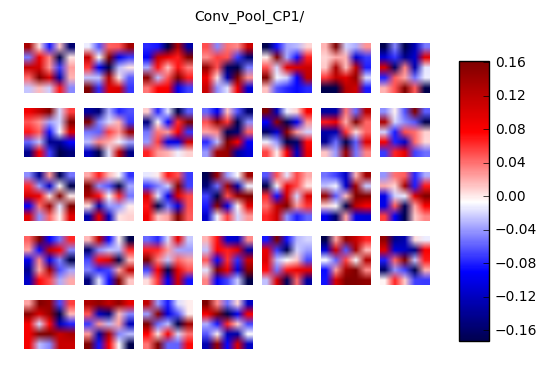

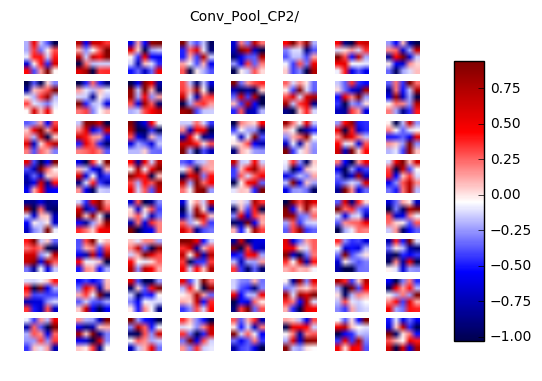

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from IPython.display import Image, display
np.set_printoptions(precision=2)

def conv_img_matrix(Mat):
    assert(int(np.shape(Mat)[0]) == int(np.shape(Mat)[1]))
    W = int(np.shape(Mat)[0])
    K = int(np.shape(Mat)[3])
    return np.array([[[sum(Mat[i, j, :, k]) for i in range(W)] for j in range(W)] for k in range(K)])

def commonprefix(m):
    "Given a list of pathnames, returns the longest common leading component"
    if not m: return ''
    s1 = min(m)
    s2 = max(m)
    for i, c in enumerate(s1):
        if c != s2[i]:
            return s1[:i]
    return s1

def show_tf_variable(v):
    w = filter(lambda x: x.name.find('weight') != -1, v)[0]
    b = filter(lambda x: x.name.find('bias') != -1, v)[0]
    weight = conv_img_matrix(w.value().eval())
    bias = b.value().eval()
    sz = len(weight)
    height = int(math.sqrt(sz))
    width = int(math.ceil(float(sz)/height))
    fig, axes = plt.subplots(nrows=height, ncols=width)
    i = -1
    for ax in axes.flat:
        ax.set_axis_off()
        i += 1
        if i >= sz: continue 
        # mat = weight[i] + bias[i]
        # max_mat = max(abs(np.max(mat)), abs(np.min(mat)))
        # im = ax.imshow(mat, vmax=max_mat, vmin=-max_mat, cmap='seismic')
        im = ax.imshow(weight[i], cmap='seismic')
    fig.suptitle(commonprefix([w.name, b.name]))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

def Conv_Variable(name):
    Conv_Var = filter(lambda x: x.name.find(name) != -1, tf.trainable_variables())
    show_tf_variable(Conv_Var)

Conv_Variable('CP1')
Conv_Variable('CP2')